In [1]:
import os
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

from diffEq import odes, plot

## Test differential equation:

$\frac{dT(t)}{dt} = r(T_{env} - T(t))$



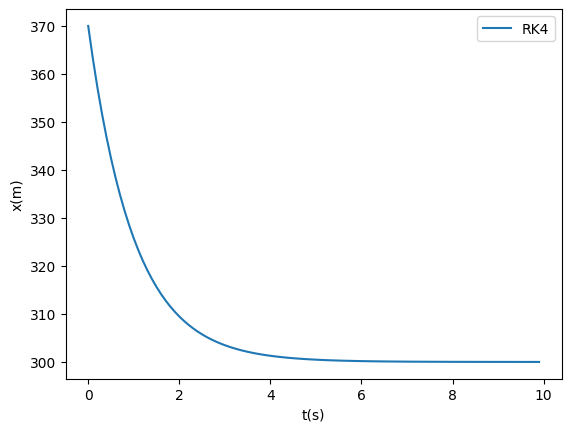

In [2]:
r = 1
T_env = 300

# args = [T]
def DT(t, args):
    return r*(T_env - args[0])

cooling_obj = odes([DT], [370])

t_list, T_list = cooling_obj.solve_Runge_Kutta(0, 10, h=0.1, stage=4)
solutions = {"RK4": (t_list, T_list)}

plot(solutions)

## Getting device for training

In [12]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

## Preparing data

In [ ]:
n_step = 400 #number of datapoints used

torch.manual_seed(0)
r_tensor = torch.rand(100, 1)
T_env_tensor = torch.rand(100, 1) * 500
T_0_tensor = T_env_tensor + torch.rand(100, 1) * 100
t_tensor = torch.linspace(0, 50, n_step)
T_tensor = T_env_tensor - (T_env_tensor - T_0_tensor)*torch.exp(-r_tensor * t_tensor)

# Split data into training and test sets
r_train, T_env_train, T_0_train, T_train = r_tensor[:80], T_env_tensor[:80], T_0_tensor[:80], T_tensor[:80]
X_train = torch.cat((r_train, T_env_train, T_0_train), 1)

X_train_mean = X_train.mean(dim=0, keepdim=True)
X_train_std = X_train.std(dim=0, keepdim=True)
X_train = (X_train - X_train_mean) / X_train_std

r_test, T_env_test, T_0_test, T_test = r_tensor[80:], T_env_tensor[80:], T_0_tensor[80:], T_tensor[80:]
X_test = torch.cat((r_test, T_env_test, T_0_test), 1)

X_test_mean = X_test.mean(dim=0, keepdim=True)
X_test_std = X_test.std(dim=0, keepdim=True)
X_test = (X_test - X_test_mean) / X_test_std

X_train_scaled = (X_train - X_train.min()) / (X_train.max() - X_train.min()) #scaled data
T_train_scaled = (T_train - T_train.min()) / (T_train.max() - T_train.min()) #scaled data
X_test_scaled = (X_test - X_test.min()) / (X_test.max() - X_test.min()) #scaled data
T_test_scaled = (T_test - T_test.min()) / (T_test.max() - T_test.min()) #scaled data


## Defining the model

In [98]:
"""
class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.linear = nn.Linear(in_features=3, out_features=n_step)

    def forward(self, x):
        return self.linear(x)
"""

class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.fc1 = nn.Linear(3, 64)    # more neurons
        self.fc2 = nn.Linear(64, n_step)  # added hidden layer

    def forward(self, x):
        x = torch.tanh(self.fc1(x))     # smooth activation
        x = self.fc2(x)
        return x

# Initiate the model
model = CoolingModel(n_step)

In [99]:
# Loss function and optimizer
loss_func = nn.MSELoss()

#optimizer = optim.SGD(model.parameters(), lr=0.01)
#optimizer = optim.Adam(model.parameters(), lr=0.001) #New optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

## Train the model

In [100]:
epochs = 5000

for epoch in range(epochs):
    T_pred = model(X_train_scaled)
    
    loss = loss_func(T_pred, T_train_scaled)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 100/5000, Loss: 0.0024
Epoch 200/5000, Loss: 0.0009
Epoch 300/5000, Loss: 0.0007
Epoch 400/5000, Loss: 0.0007
Epoch 500/5000, Loss: 0.0006
Epoch 600/5000, Loss: 0.0005
Epoch 700/5000, Loss: 0.0005
Epoch 800/5000, Loss: 0.0005
Epoch 900/5000, Loss: 0.0005
Epoch 1000/5000, Loss: 0.0004
Epoch 1100/5000, Loss: 0.0004
Epoch 1200/5000, Loss: 0.0004
Epoch 1300/5000, Loss: 0.0004
Epoch 1400/5000, Loss: 0.0004
Epoch 1500/5000, Loss: 0.0004
Epoch 1600/5000, Loss: 0.0003
Epoch 1700/5000, Loss: 0.0003
Epoch 1800/5000, Loss: 0.0003
Epoch 1900/5000, Loss: 0.0003
Epoch 2000/5000, Loss: 0.0003
Epoch 2100/5000, Loss: 0.0003
Epoch 2200/5000, Loss: 0.0003
Epoch 2300/5000, Loss: 0.0003
Epoch 2400/5000, Loss: 0.0003
Epoch 2500/5000, Loss: 0.0003
Epoch 2600/5000, Loss: 0.0003
Epoch 2700/5000, Loss: 0.0003
Epoch 2800/5000, Loss: 0.0003
Epoch 2900/5000, Loss: 0.0003
Epoch 3000/5000, Loss: 0.0003
Epoch 3100/5000, Loss: 0.0003
Epoch 3200/5000, Loss: 0.0003
Epoch 3300/5000, Loss: 0.0003
Epoch 3400/5000, Lo

In [101]:
model.eval()
with torch.no_grad():
    T_pred_test = model(X_test_scaled)
    test_loss = loss_func(T_pred_test, T_test_scaled)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0035


In [102]:
for name, param in model.named_parameters():
    print(name, param.data)

fc1.weight tensor([[-0.0029, -0.4327, -0.1515],
        [ 0.0142, -0.4234, -0.1540],
        [-0.0141,  0.4287,  0.1538],
        [ 0.0197, -0.4389, -0.1549],
        [ 0.0097, -0.4176, -0.1527],
        [ 0.0306, -0.4290, -0.1557],
        [-0.0092,  0.4240,  0.1532],
        [ 0.0145, -0.4394, -0.1535],
        [-0.0134,  0.5530,  0.1672],
        [-0.0120,  0.4240,  0.1532],
        [-0.0999, -0.4043, -0.1308],
        [-0.0110, -0.4143, -0.1506],
        [-0.0085,  0.4222,  0.1524],
        [ 0.0177, -0.4286, -0.1545],
        [ 0.0020,  0.4261,  0.1503],
        [-0.0058,  0.4303,  0.1527],
        [-0.0022, -0.4124, -0.1525],
        [ 0.0266,  0.3985,  0.1454],
        [-0.0010,  0.4264,  0.1517],
        [-0.0148, -0.4150, -0.1497],
        [ 0.0122, -0.4329, -0.1538],
        [-0.0072,  0.4466,  0.1536],
        [ 0.0799, -0.4833, -0.1658],
        [-0.0306, -0.4051, -0.1473],
        [ 0.0075, -0.4247, -0.1523],
        [-0.0430,  0.4501,  0.1592],
        [-0.0137,  0.4274, 

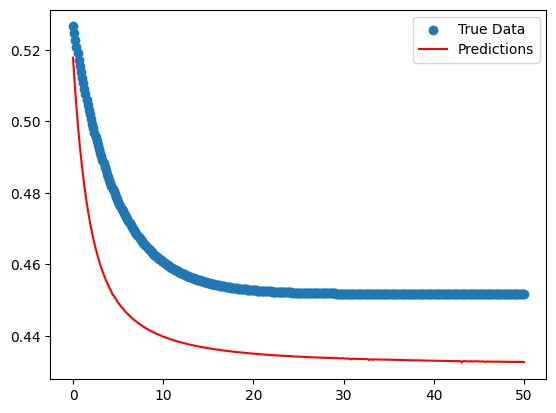

In [103]:
plt.scatter(t_tensor, T_test_scaled[-1], label="True Data")
plt.plot(t_tensor, T_pred_test[-1], color="red", label="Predictions")
plt.legend()
plt.show()